In [32]:
import os, numpy as np, soundfile as sf

base = '/Users/muslim/Desktop/Education/MachineLearning/BabyCryClassification-main/data/no_cry'
os.makedirs(base, exist_ok=True)

sr = 16000
dur_s = 2.5
N = int(sr*dur_s)

def write(name, y):
    y = y / (np.max(np.abs(y)) + 1e-9)
    sf.write(os.path.join(base, name), y, sr)

# 1) pure silence
for i in range(10):
    write(f'silence_{i:02d}.wav', np.zeros(N, dtype=np.float32))

# 2) low-level white noise (very quiet room hiss)
for i in range(10):
    y = 0.003*np.random.randn(N).astype(np.float32)
    write(f'room_hiss_{i:02d}.wav', y)

# 3) band-limited “aircon/street” noise (100–800 Hz)
def band_noise(n, sr, f1=100, f2=800):
    y = np.random.randn(n)
    Y = np.fft.rfft(y)
    freqs = np.fft.rfftfreq(n, 1/sr)
    mask = (freqs>=f1)&(freqs<=f2)
    Y[~mask] = 0
    yb = np.fft.irfft(Y, n)
    return (yb/np.max(np.abs(yb)+1e-9)).astype(np.float32)

for i in range(10):
    write(f'band_noise_{i:02d}.wav', 0.01*band_noise(N, sr))

# 4) mic “rubble”/handling thumps (very low freq AM)
for i in range(10):
    t = np.linspace(0, dur_s, N, endpoint=False)
    env = (np.sin(2*np.pi*0.8*t)+1)/2  # slow amplitude wiggle
    y = 0.004*np.random.randn(N).astype(np.float32)*env
    write(f'mic_rubble_{i:02d}.wav', y)


In [34]:
import os
import numpy as np
import pandas as pd
import librosa

data_dir = '/Users/muslim/Desktop/Education/MachineLearning/BabyCryClassification-main/data'
classes = ['discomfort', 'hungry', 'belly_pain', 'burping', 'lonely', 'dont_know', 'no_cry']

features = []
labels = []

sr_target = 16000
energy_threshold = 0.005  # tweak if too sensitive

def feat_mean_var(arr, axis=1):
    mu = np.mean(arr, axis=axis)
    var = np.var(arr, axis=axis)
    return np.concatenate([mu, var], axis=0)

for category in classes:
    category_path = os.path.join(data_dir, category)
    if not os.path.exists(category_path):
        continue

    for filename in os.listdir(category_path):
        if not filename.endswith('.wav'):
            continue

        file_path = os.path.join(category_path, filename)
        try:
            y, sr = librosa.load(file_path, sr=sr_target, mono=True)

            # skip empty files
            if len(y) == 0:
                continue

            # normalize
            y = y / (np.max(np.abs(y)) + 1e-9)

            # detect silence / background
            rms_energy = np.mean(librosa.feature.rms(y=y))
            if rms_energy < energy_threshold:
                # treat this as a non-cry sample
                features.append(np.zeros(128, dtype=np.float32))  # placeholder vector
                labels.append('no_cry')
                continue

            # extract features
            mfcc = librosa.feature.mfcc(y=y, sr=sr_target, n_mfcc=20)
            mfcc_d1 = librosa.feature.delta(mfcc, order=1)
            mfcc_d2 = librosa.feature.delta(mfcc, order=2)

            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr_target)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr_target)
            spec_roll = librosa.feature.spectral_rolloff(y=y, sr=sr_target, roll_percent=0.85)
            zcr = librosa.feature.zero_crossing_rate(y)

            fvec = np.concatenate([
                feat_mean_var(mfcc),
                feat_mean_var(mfcc_d1),
                feat_mean_var(mfcc_d2),
                feat_mean_var(spec_cent),
                feat_mean_var(spec_bw),
                feat_mean_var(spec_roll),
                feat_mean_var(zcr)
            ], axis=0).astype(np.float32)

            features.append(fvec)
            labels.append(category)

        except Exception as e:
            print(f"Error with {file_path}: {e}")
            continue

# build dataframe
X = np.vstack(features)
df = pd.DataFrame(X)
df['label'] = labels
df.to_csv('child_cry_data_strong_features_v2.csv', index=False)

In [35]:
print('Saved child_cry_data_strong_features_v2.csv with shape:', df.shape)

Saved child_cry_data_strong_features_v2.csv with shape: (1039, 129)


In [40]:
import pandas as pd
df = pd.read_csv('child_cry_data_strong_features_v2.csv')
print(df['label'].value_counts())


label
hungry        415
lonely        371
dont_know      85
burping        60
discomfort     42
no_cry         42
belly_pain     24
Name: count, dtype: int64


In [48]:
import os
import librosa
import soundfile as sf
import numpy as np
import random
from tqdm import tqdm

# Path to your dataset
data_root = '/Users/muslim/Desktop/Education/MachineLearning/BabyCryClassification-main/data'
target_count = 300  # target samples per class
sr = 16000  # sample rate

# --------------------------------------------------------
# AUGMENTATION FUNCTION
# --------------------------------------------------------
def augment_audio(y, sr):
    # 1. Random pitch shift (±3 semitones)
    y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=random.uniform(-3, 3))
    
    # 2. Random time stretch (±15%)
    y = librosa.effects.time_stretch(y=y, rate=random.uniform(0.85, 1.15))
    
    # 3. Add gentle background noise
    y = y + 0.005 * np.random.randn(len(y))
    
    # Normalize to avoid clipping
    return y / (np.max(np.abs(y)) + 1e-9)

# --------------------------------------------------------
# MAIN LOOP — augment weak classes
# --------------------------------------------------------
for folder in os.listdir(data_root):
    class_path = os.path.join(data_root, folder)
    if not os.path.isdir(class_path):
        continue
    
    files = [f for f in os.listdir(class_path) if f.endswith('.wav')]
    if len(files) >= target_count:
        print(f'Skipping {folder}, already has {len(files)} files.')
        continue
    
    print(f'Augmenting {folder}: {len(files)} → {target_count}')
    for i in tqdm(range(target_count - len(files))):
        src = random.choice(files)
        src_path = os.path.join(class_path, src)
        try:
            y, sr = librosa.load(src_path, sr=sr)
            y_aug = augment_audio(y, sr)
            out_name = f'{os.path.splitext(src)[0]}_aug{i:03d}.wav'
            sf.write(os.path.join(class_path, out_name), y_aug, sr)
        except Exception as e:
            print(f'Error augmenting {src_path}: {e}')
            continue

# --------------------------------------------------------
# VERIFY TOTAL FILE COUNT
# --------------------------------------------------------
import os

data_root = '/Users/muslim/Desktop/Education/MachineLearning/BabyCryClassification-main/data'

total_files = 0
for c in os.listdir(data_root):
    class_path = os.path.join(data_root, c)
    if not os.path.isdir(class_path):
        continue
    total_files += len([f for f in os.listdir(class_path) if f.endswith('.wav')])

print("\n✅ Augmentation complete.")
print("Total .wav files across all classes:", total_files)


Skipping belly_pain, already has 300 files.
Skipping discomfort, already has 300 files.
Skipping lonely, already has 371 files.
Skipping burping, already has 300 files.
Skipping tired, already has 300 files.
Skipping hungry, already has 417 files.
Skipping dont_know, already has 300 files.
Skipping no_cry, already has 300 files.

✅ Augmentation complete.
Total .wav files across all classes: 2588


In [50]:
import os
import numpy as np
import librosa
import librosa.display
from tqdm import tqdm
import pickle

# Paths
data_root = '/Users/muslim/Desktop/Education/MachineLearning/BabyCryClassification-main/data'
output_dir = '/Users/muslim/Desktop/Education/MachineLearning/BabyCryClassification-main/features'
os.makedirs(output_dir, exist_ok=True)

sr = 16000
n_mels = 128
duration = 2.5  # seconds
hop_length = 512
samples = int(sr * duration)
img_size = 128

X = []
y = []
labels = sorted([f for f in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, f))])

print(f"Classes: {labels}")

for label in labels:
    folder = os.path.join(data_root, label)
    files = [f for f in os.listdir(folder) if f.endswith('.wav')]
    for f_name in tqdm(files, desc=f"Processing {label}"):
        f_path = os.path.join(folder, f_name)
        try:
            y_audio, sr = librosa.load(f_path, sr=sr)
            if len(y_audio) < samples:
                y_audio = np.pad(y_audio, (0, samples - len(y_audio)))
            else:
                y_audio = y_audio[:samples]

            mel_spec = librosa.feature.melspectrogram(
                y=y_audio,
                sr=sr,
                n_mels=n_mels,
                hop_length=hop_length
            )
            log_mel = librosa.power_to_db(mel_spec, ref=np.max)
            log_mel = librosa.util.fix_length(log_mel, size=img_size, axis=1)
            X.append(log_mel)
            y.append(label)
        except Exception as e:
            print(f"Error with {f_path}: {e}")
            continue

X = np.array(X, dtype=np.float32)
y = np.array(y)



Classes: ['belly_pain', 'burping', 'discomfort', 'dont_know', 'hungry', 'lonely', 'no_cry', 'tired']


Processing tired: 100%|██████████████████████| 300/300 [00:01<00:00, 267.31it/s]


In [52]:
print(f"\n✅ Feature extraction complete: {X.shape} features for {len(y)} samples.")

# Save for later model training
with open(os.path.join(output_dir, 'features.pkl'), 'wb') as f:
    pickle.dump({'X': X, 'y': y, 'labels': labels}, f)

print(f"Saved features to {os.path.join(output_dir, 'features.pkl')}")


✅ Feature extraction complete: (2588, 128, 128) features for 2588 samples.
Saved features to /Users/muslim/Desktop/Education/MachineLearning/BabyCryClassification-main/features/features.pkl


In [4]:
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load features
with open('/Users/muslim/Desktop/Education/MachineLearning/BabyCryClassification-main/features/features.pkl', 'rb') as f:
    data = pickle.load(f)

X = data['X']
y = data['y']
labels = data['labels']

# Encode labels
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)
num_classes = len(encoder.classes_)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# Reshape for CNN input (samples, height, width, channels)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Define CRNN + Attention model
inputs = layers.Input(shape=(128, 128, 1))

x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

# Flatten time dimension for LSTM
x = layers.Reshape((x.shape[1]*x.shape[2], x.shape[3]))(x)

x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)

# Attention layer
attention = layers.Dense(1, activation='tanh')(x)
attention = layers.Softmax(axis=1)(attention)
x = layers.Multiply()([x, attention])
x = layers.Lambda(lambda z: tf.reduce_sum(z, axis=1))(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 256, 256)  │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256, 256)  │    394,240 │ reshape_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256, 1)    │        257 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 256, 1)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256, 256)  │          0 │ bidirectional_1[… │
│                     │                   │            │ softmax[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 256)       │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8)         │      1,032 │ dropout[0][0]   

 Total params: 799,881 (3.05 MB)

 Trainable params: 798,985 (3.05 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 63s 946ms/step - accuracy: 0.3908 - loss: 1.6244 - val_accuracy: 0.1988 - val_loss: 2.6313
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 60s 914ms/step - accuracy: 0.4889 - loss: 1.4232 - val_accuracy: 0.2954 - val_loss: 2.1119
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 56s 865ms/step - accuracy: 0.5072 - loss: 1.3282 - val_accuracy: 0.4691 - val_loss: 1.4676
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 64s 984ms/step - accuracy: 0.5348 - loss: 1.2670 - val_accuracy: 0.3649 - val_loss: 1.6521
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.5594 - loss: 1.1980 - val_accuracy: 0.4131 - val_loss: 1.7331
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.5976 - loss: 1.1110 - val_accuracy: 0.3050 - val_loss: 3.0896
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.6232 - loss: 1.0079 - val_accuracy: 0.6390 - val_loss: 1.0017
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 59s 905ms/step - accuracy: 0.6473 - loss: 0.9844 - val_accuracy: 0.2

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step

Classification Report:
               precision    recall  f1-score   support

  belly_pain       1.00      0.78      0.88        60
     burping       0.98      0.85      0.91        60
  discomfort       1.00      0.55      0.71        60
   dont_know       0.58      0.65      0.61        60
      hungry       0.63      0.96      0.76        84
      lonely       0.97      0.89      0.93        74
      no_cry       0.97      1.00      0.98        60
       tired       0.87      0.88      0.88        60

    accuracy                           0.83       518
   macro avg       0.88      0.82      0.83       518
weighted avg       0.87      0.83      0.83       518



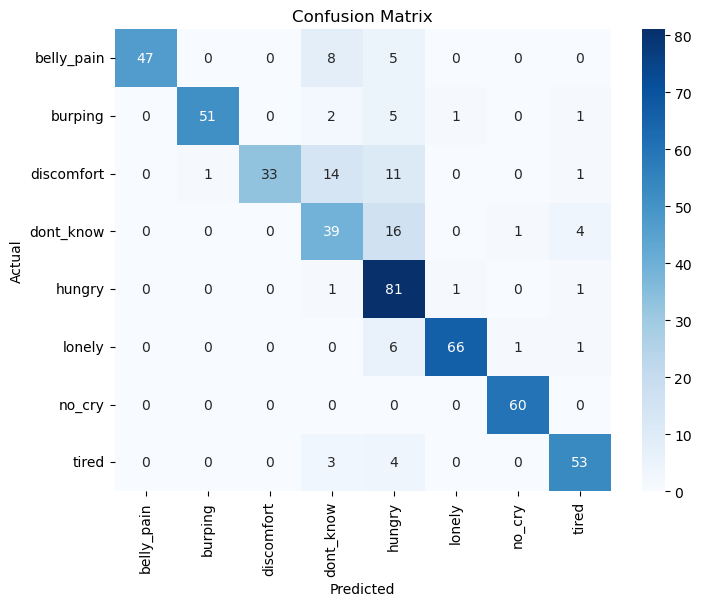

In [5]:
y_pred = np.argmax(model.predict(X_test), axis=1)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [12]:
import pickle
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# reload your dataset
df = pd.read_csv('child_cry_data_strong_features_v2.csv')

# rebuild label encoder
label_encoder = LabelEncoder()
label_encoder.fit(df['label'])

# save both model and label order
model.save("BabyCry_CRNN_Attention_Final.keras")
pickle.dump(label_encoder.classes_, open("label_classes.pkl","wb"))

print("✅ Model and label classes saved successfully!")
print("Class order:", list(label_encoder.classes_))


✅ Model and label classes saved successfully!
Class order: ['belly_pain', 'burping', 'discomfort', 'dont_know', 'hungry', 'lonely', 'no_cry']


In [14]:
# -*- coding: utf-8 -*-
import os
import io
import json
import math
import warnings
import numpy as np
import pandas as pd

import librosa
import soundfile as sf

from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore", category=UserWarning)

# ----------------------------
# CONFIG
# ----------------------------
DATA_DIR = '/Users/muslim/Desktop/Education/MachineLearning/BabyCryClassification-main/data'
SR = 16000
DURATION = 2.5          # seconds per sample target
N = int(SR * DURATION)
HOP = 256               # smaller hop for better time resolution
FRAME = 1024
F0_MIN = 100
F0_MAX = 800
HYPER_F0 = 1000         # hyperphonation threshold from literature
CLASSES = ['belly_pain','burping','discomfort','dont_know','hungry','lonely','no_cry','tired']

# Which labels we treat as "typical cry" for anomaly training
# We exclude 'no_cry' and 'dont_know' from the "normal" set.
TYPICAL_CLASSES = ['belly_pain','burping','discomfort','hungry','lonely','tired']

OUT_CSV = 'cry_acoustic_features_v2.csv'
MODEL_PATH = 'autism_anomaly_ocsvm.pkl'

# ----------------------------
# UTILITIES
# ----------------------------
def safe_load(path, sr=SR, target_len=N):
    y, s = librosa.load(path, sr=sr, mono=True)
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)))
    else:
        y = y[:target_len]
    # normalize to avoid level issues
    peak = np.max(np.abs(y)) + 1e-9
    y = y / peak
    return y

def compute_f0_features(y, sr=SR):
    # Use probabilistic YIN for robust F0
    f0, vflag, vprob = librosa.pyin(y, fmin=F0_MIN, fmax=F0_MAX, sr=sr, frame_length=FRAME, hop_length=HOP)
    if f0 is None:
        return dict(
            f0_mean=0, f0_std=0, f0_median=0, f0_iqr=0,
            f0_cv=0, f0_jitter=0, f0_voiced_ratio=0,
            f0_hyper_ratio=0
        )
    # voiced mask
    valid = ~np.isnan(f0)
    f0_v = f0[valid]
    voiced_ratio = float(np.mean(valid)) if len(valid) > 0 else 0.0
    if len(f0_v) == 0:
        return dict(
            f0_mean=0, f0_std=0, f0_median=0, f0_iqr=0,
            f0_cv=0, f0_jitter=0, f0_voiced_ratio=voiced_ratio,
            f0_hyper_ratio=0
        )

    f0_mean = float(np.mean(f0_v))
    f0_std = float(np.std(f0_v))
    f0_median = float(np.median(f0_v))
    q1, q3 = np.percentile(f0_v, [25, 75])
    f0_iqr = float(q3 - q1)
    f0_cv = float(f0_std / (f0_mean + 1e-9))

    # "Jitter-like": mean absolute period-to-period diff normalized
    # Convert F0 to period T = 1/f0 to emulate classic jitter idea
    T = 1.0 / (f0_v + 1e-9)
    if len(T) > 1:
        jitter = float(np.mean(np.abs(np.diff(T))) / (np.mean(T) + 1e-9))
    else:
        jitter = 0.0

    # Hyperphonation ratio: fraction of frames over threshold
    # Note: pyin caps at f0_max. True hyperphonation >1000 Hz may not appear if we set 800.
    # We still compute >800 as proxy. If you want >1000 strictly, increase F0_MAX.
    hyper_ratio = float(np.mean(f0_v > min(HYPER_F0, F0_MAX)))

    return dict(
        f0_mean=f0_mean, f0_std=f0_std, f0_median=f0_median, f0_iqr=f0_iqr,
        f0_cv=f0_cv, f0_jitter=jitter, f0_voiced_ratio=voiced_ratio,
        f0_hyper_ratio=hyper_ratio
    )

def compute_energy_pause_features(y):
    # Frame energy
    r = librosa.feature.rms(y=y, frame_length=FRAME, hop_length=HOP)[0]
    rms_mean = float(np.mean(r))
    rms_std = float(np.std(r))
    rms_cv = float(rms_std / (rms_mean + 1e-9))

    # Silence ratio by energy threshold relative to median
    thr = np.median(r) * 0.6
    silence_ratio = float(np.mean(r < thr))

    return dict(rms_mean=rms_mean, rms_std=rms_std, rms_cv=rms_cv, silence_ratio=silence_ratio)

def compute_spectral_features(y, sr=SR):
    S = np.abs(librosa.stft(y, n_fft=FRAME, hop_length=HOP))
    # spectral centroid stats
    sc = librosa.feature.spectral_centroid(S=S, sr=sr)[0]
    sc_mean = float(np.mean(sc))
    sc_std = float(np.std(sc))
    sc_cv = float(sc_std / (sc_mean + 1e-9))

    # spectral flatness (tonality vs noisiness)
    flatness = librosa.feature.spectral_flatness(S=S)[0]
    flat_mean = float(np.mean(flatness))
    flat_std = float(np.std(flatness))

    # HNR proxy using harmonic-percussive source separation
    harm = librosa.effects.harmonic(y)
    noise = y - harm
    hnr = float((np.mean(np.abs(harm)) + 1e-9) / (np.mean(np.abs(noise)) + 1e-9))

    return dict(
        sc_mean=sc_mean, sc_std=sc_std, sc_cv=sc_cv,
        flat_mean=flat_mean, flat_std=flat_std,
        hnr=hnr
    )

def lpc_formants(y, sr=SR, lpc_order=12):
    """
    Estimate first two formants F1, F2 via LPC roots.
    This is an approximation but aligns with common practice in literature.
    """
    # pre-emphasis
    y = librosa.effects.preemphasis(y)
    # short window around the max energy to stabilize
    r = librosa.feature.rms(y=y, frame_length=FRAME, hop_length=HOP)[0]
    idx = np.argmax(r)
    start = max(0, idx * HOP - FRAME)
    seg = y[start:start + 4*FRAME]
    if len(seg) < 2*FRAME:
        seg = y[:2*FRAME] if len(y) >= 2*FRAME else np.pad(y, (0, 2*FRAME-len(y)))
    # LPC
    try:
        a = librosa.lpc(seg, order=lpc_order)
        # roots of LPC polynomial
        rts = np.roots(a)
        rts = rts[np.imag(rts) >= 0.01]
        ang = np.arctan2(np.imag(rts), np.real(rts))
        freqs = ang * (sr / (2*np.pi))
        freqs = np.sort(freqs)
        # typical speech-ish formant band limits, keep plausible ones
        freqs = freqs[(freqs > 90) & (freqs < 5000)]
        F1 = float(freqs[0]) if len(freqs) > 0 else 0.0
        F2 = float(freqs[1]) if len(freqs) > 1 else 0.0
    except Exception:
        F1, F2 = 0.0, 0.0
    return dict(F1=F1, F2=F2)

def extract_all_features(y, sr=SR):
    feats = {}
    feats.update(compute_f0_features(y, sr))
    feats.update(compute_energy_pause_features(y))
    feats.update(compute_spectral_features(y, sr))
    feats.update(lpc_formants(y, sr))
    return feats


In [16]:
# ----------------------------
# PASS 1: Extract features CSV
# ----------------------------
records = []
for cls in CLASSES:
    folder = os.path.join(DATA_DIR, cls)
    if not os.path.isdir(folder):
        continue
    for fn in os.listdir(folder):
        if not fn.lower().endswith('.wav'):
            continue
        path = os.path.join(folder, fn)
        try:
            y = safe_load(path)
            f = extract_all_features(y, SR)
            f['label'] = cls
            f['file'] = fn
            records.append(f)
        except Exception as e:
            # skip corrupted files
            continue

df = pd.DataFrame(records)
df.to_csv(OUT_CSV, index=False)
print(f"✅ Saved {OUT_CSV} with shape: {df.shape}")



✅ Saved cry_acoustic_features_v2.csv with shape: (2588, 22)


In [17]:
# ----------------------------
# PASS 2: Train anomaly detector
# ----------------------------
# We define "typical" as all known cry categories except 'no_cry' and 'dont_know'
df_train = df[df['label'].isin(TYPICAL_CLASSES)].copy()

feature_cols = [c for c in df.columns if c not in ['label','file']]
X = df_train[feature_cols].fillna(0).values

# One-Class SVM: learns the support of "normal" cries
ocsvm = Pipeline([
    ('scaler', StandardScaler()),
    ('oc', OneClassSVM(kernel='rbf', gamma='scale', nu=0.08))  # nu ~ fraction flagged as outliers
])
ocsvm.fit(X)

# Save model
import pickle
with open(MODEL_PATH, 'wb') as f:
    pickle.dump({'pipeline': ocsvm, 'features': feature_cols, 'sr': SR, 'duration': DURATION}, f)

print(f"✅ Saved anomaly model to {MODEL_PATH}")


✅ Saved anomaly model to autism_anomaly_ocsvm.pkl


In [30]:
model.save('/Users/muslim/Desktop/Education/MachineLearning/BabyCryClassification-main/BabyCry_CRNN_Attention.h5')
print("✅ Model saved as BabyCry_CRNN_Attention.h5")

✅ Model saved as BabyCry_CRNN_Attention.h5


In [32]:
model.save_weights("BabyCry_CRNN_Attention_Final.weights.h5")
print("✅ Clean weights saved. No Lambda demons inside.")


✅ Clean weights saved. No Lambda demons inside.


In [36]:
import numpy as np
import librosa
import pickle
import tensorflow as tf

# Load model and labels
from tensorflow.keras import layers, models

def build_babycry_model(num_classes=7):
    inputs = layers.Input(shape=(128, 128, 1))
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Reshape((x.shape[1]*x.shape[2], x.shape[3]))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    att = layers.Dense(1, activation='tanh')(x)
    att = layers.Softmax(axis=1)(att)
    x = layers.Multiply()([x, att])
    x = layers.Lambda(lambda z: tf.reduce_sum(z, axis=1))(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

model = build_babycry_model()
model.load_weights("BabyCry_CRNN_Attention_Final.weights.h5")

labels = pickle.load(open("label_classes.pkl", "rb"))

# Load one of your TRAINING .wav files, not a random test
y, sr = librosa.load("data/belly_pain/643D64AD-B711-469A-AF69-55C0D5D3E30F-1430138591-1.0-m-72-bp.wav", sr=16000)
mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, hop_length=512)
logmel = librosa.power_to_db(mel, ref=np.max)
logmel = librosa.util.fix_length(logmel, size=128, axis=1)
logmel = (logmel - np.mean(logmel)) / (np.std(logmel) + 1e-9)
logmel = logmel[np.newaxis, ..., np.newaxis]

pred = model.predict(logmel)[0]
print({labels[i]: float(pred[i]) for i in range(len(labels))})


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
{'belly_pain': 0.14625076949596405, 'burping': 0.14213134348392487, 'discomfort': 0.14610731601715088, 'dont_know': 0.15742601454257965, 'hungry': 0.13964320719242096, 'lonely': 0.13995645940303802, 'no_cry': 0.1284847855567932}
